**Inhalt:** Selbständige Übung in Gruppen

**Nötige Skills:** Time Series

**Lernziele:**
- Selbständig Daten explorieren und Storyideen testen

# Das Beispiel

Covid-Daten aus den Schweizer Kantonen.

- Auswertung einzeln bzw. anhand von Gruppen
- Generierung von Story-Ideen und Plotten

Die Daten stammen von dieser Quelle: https://github.com/openZH/covid_19

# Vorbereitung

In [1]:
import pandas as pd

In [2]:
import numpy as np

## Daten laden

### 1. Fallzahlen

Wir können die Daten direkt von Github beziehen

In [3]:
path = 'https://github.com/openZH/covid_19/raw/master/COVID19_Fallzahlen_CH_total_v2.csv'

In [4]:
df = pd.read_csv(path)

In [5]:
df.head(5)

,date,time,abbreviation_canton_and_fl,ncumul_tested,ncumul_conf,new_hosp,current_hosp,current_icu,current_vent,ncumul_released,ncumul_deceased,source,current_isolated,current_quarantined,current_quarantined_riskareatravel,current_quarantined_total
0,2020-02-01,00:00,GE,109.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,https://infocovid.smc.unige.ch/,1.0,0.0,0.0,NaN
1,2020-02-02,00:00,GE,115.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,https://infocovid.smc.unige.ch/,1.0,0.0,0.0,NaN
2,2020-02-03,00:00,GE,136.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,https://infocovid.smc.unige.ch/,1.0,0.0,0.0,NaN
3,2020-02-04,00:00,GE,156.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,https://infocovid.smc.unige.ch/,1.0,0.0,0.0,NaN
4,2020-02-05,00:00,GE,169.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,https://infocovid.smc.unige.ch/,1.0,0.0,0.0,NaN


In [6]:
df.tail()

,date,time,abbreviation_canton_and_fl,ncumul_tested,ncumul_conf,new_hosp,current_hosp,current_icu,current_vent,ncumul_released,ncumul_deceased,source,current_isolated,current_quarantined,current_quarantined_riskareatravel,current_quarantined_total
21084,2022-09-01,12:00,BS,NaN,94403.0,NaN,40.0,3.0,NaN,93864.0,300.0,https://www.gesundheit.bs.ch,241.0,0.0,NaN,NaN
21085,2022-09-02,NaN,NW,NaN,20005.0,NaN,1.0,0.0,NaN,NaN,38.0,http://www.nw.ch/coronastatistik,NaN,NaN,NaN,NaN
21086,2022-09-02,NaN,SO,NaN,127762.0,NaN,5.0,0.0,NaN,NaN,373.0,https://corona.so.ch/bevoelkerung/daten/,NaN,NaN,NaN,NaN
21087,2022-09-02,00:00,GE,NaN,234475.0,NaN,225.0,1.0,NaN,NaN,NaN,https://infocovid.smc.unige.ch/,NaN,NaN,NaN,NaN
21088,2022-09-02,12:00,BS,NaN,94461.0,NaN,33.0,2.0,NaN,93875.0,300.0,https://www.gesundheit.bs.ch,286.0,0.0,NaN,NaN


### 2. Hilfsdaten zu Kantonen

Vorbereitetes File mit einigen Angaben, die wir nutzen können

In [7]:
df_c = pd.read_excel('dataprojects/Covid/cantons.xlsx')

In [8]:
df_c['bevölkerung'] = df_c['bevölkerung'].astype(int)

In [9]:
df_c.head()

,kanton,name,bevölkerung,grossregion
0,AG,Aargau,678207,Nordwestschweiz
1,AI,Appenzell IR,16145,Ostschweiz
2,AR,Appenzell AR,55234,Ostschweiz
3,BE,Bern,1034977,Mittelland
4,BL,Baselland,288132,Nordwestschweiz


# Daten checken

In [10]:
df.dtypes

date                                   object
time                                   object
abbreviation_canton_and_fl             object
ncumul_tested                         float64
ncumul_conf                           float64
new_hosp                              float64
current_hosp                          float64
current_icu                           float64
current_vent                          float64
ncumul_released                       float64
ncumul_deceased                       float64
source                                 object
current_isolated                      float64
current_quarantined                   float64
current_quarantined_riskareatravel    float64
current_quarantined_total             float64
dtype: object

In [11]:
df.shape

(21089, 16)

# Daten arrangieren

Unser Ziel sind zwei Dataframes:
- eines mit den kumulierten Fallzahlen (das sind die Werte, die wir in der Spalte "ncumul_conf" erhalten): `df_kum`
- eines mit der täglichen Indizenz (das müssen wir erst noch berechnen): `df_inz`

Wir wollen beide Dataframes im "wide"-Format haben. Das heisst:
- Die Indexspalte enthält das Datum (für jeden Tag genau eine Zeile)
- Die Kantone sind auf die restlichen Spalten aufgeteilt (AG, AI, AR, ...)

Um an diesen Punkt zu kommen, brauchen wir die Funktion `pivot()`. Sie erfordert drei Angaben:
- `index`: Aus welcher Spalte des originalen DF sollen die **Indexwerte** des neuen DF gebildet werden?
- `columns`: Aus welcher Spalte des orignalen DF sollen die **Spalten** des neuen DF gebildet werden?
- `values`: Aus welcher Spalte des orignalen DF sollen die **Werte** des neuen DF gebildet werden?

In [12]:
df_kum = df.pivot(index='date', columns='abbreviation_canton_and_fl', values='ncumul_conf')

In [13]:
df_kum.head()

abbreviation_canton_and_fl,AG,AI,AR,BE,BL,BS,FL,FR,GE,GL,...,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_kum.tail()

abbreviation_canton_and_fl,AG,AI,AR,BE,BL,BS,FL,FR,GE,GL,...,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
date,,,,,,,,,,,,,,,,,,,,,
2022-08-29,NaN,NaN,NaN,NaN,141181.0,94196.0,19146.0,NaN,234179.0,NaN,...,36027.0,NaN,NaN,130742.0,167315.0,NaN,NaN,NaN,55801.0,720317.0
2022-08-30,NaN,NaN,NaN,NaN,NaN,94269.0,19161.0,NaN,234261.0,NaN,...,36050.0,127480.0,NaN,NaN,167478.0,NaN,NaN,NaN,55814.0,720923.0
2022-08-31,NaN,NaN,NaN,NaN,NaN,94340.0,19166.0,NaN,234356.0,NaN,...,36078.0,127565.0,NaN,NaN,167591.0,NaN,NaN,NaN,55861.0,721492.0
2022-09-01,NaN,NaN,NaN,NaN,NaN,94403.0,19183.0,NaN,234431.0,NaN,...,36103.0,127670.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-02,NaN,NaN,NaN,NaN,NaN,94461.0,NaN,NaN,234475.0,NaN,...,NaN,127762.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Nullen und NaNs

Ein Problem sind die NaNs - nicht für jeden Tag existiert eine Meldung aus jedem Kanton. Wir müssen die Leerstellen mit dem jeweils vorherigen Wert füllen. Dazu benutzen wir `.ffill()`

In [15]:
df_kum = df_kum.ffill()

In [16]:
df_kum.head()

abbreviation_canton_and_fl,AG,AI,AR,BE,BL,BS,FL,FR,GE,GL,...,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_kum.tail()

abbreviation_canton_and_fl,AG,AI,AR,BE,BL,BS,FL,FR,GE,GL,...,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
date,,,,,,,,,,,,,,,,,,,,,
2022-08-29,202809.0,6545.0,2867.0,395976.0,141181.0,94196.0,19146.0,154996.0,234179.0,11406.0,...,36027.0,127171.0,57450.0,130742.0,167315.0,15432.0,335338.0,150970.0,55801.0,720317.0
2022-08-30,202809.0,6545.0,2867.0,395976.0,141181.0,94269.0,19161.0,154996.0,234261.0,11406.0,...,36050.0,127480.0,57450.0,130742.0,167478.0,15432.0,335338.0,150970.0,55814.0,720923.0
2022-08-31,202809.0,6545.0,2867.0,395976.0,141181.0,94340.0,19166.0,154996.0,234356.0,11406.0,...,36078.0,127565.0,57450.0,130742.0,167591.0,15432.0,335338.0,150970.0,55861.0,721492.0
2022-09-01,202809.0,6545.0,2867.0,395976.0,141181.0,94403.0,19183.0,154996.0,234431.0,11406.0,...,36103.0,127670.0,57450.0,130742.0,167591.0,15432.0,335338.0,150970.0,55861.0,721492.0
2022-09-02,202809.0,6545.0,2867.0,395976.0,141181.0,94461.0,19183.0,154996.0,234475.0,11406.0,...,36103.0,127762.0,57450.0,130742.0,167591.0,15432.0,335338.0,150970.0,55861.0,721492.0


Nächster Schritt: Die NaN am Anfang müssen durch Nullen ersetzt werden.

In [18]:
df_kum = df_kum.fillna(0).astype(int)

In [19]:
df_kum.head()

abbreviation_canton_and_fl,AG,AI,AR,BE,BL,BS,FL,FR,GE,GL,...,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-02-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-02-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-02-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-02-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Indexspalte

Datentyp auf 'datetime':

In [20]:
df_kum.index = pd.to_datetime(df_kum.index)

... und noch etwas Verschönerung:

In [21]:
df_kum.index.name = None
df_kum.columns.name = None

### Inzidenzen

Um aus den kumulierten Fallzahlen die täglichen Inzidenzen zu erhalten, nutzen wir `diff()`

In [22]:
df_inz = df_kum.diff()

In [23]:
df_inz.head()

,AG,AI,AR,BE,BL,BS,FL,FR,GE,GL,...,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
2020-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
df_inz.tail()

,AG,AI,AR,BE,BL,BS,FL,FR,GE,GL,...,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
2022-08-29,0.0,0.0,0.0,0.0,126.0,103.0,35.0,0.0,103.0,0.0,...,27.0,0.0,0.0,0.0,219.0,0.0,0.0,0.0,21.0,346.0
2022-08-30,0.0,0.0,0.0,0.0,0.0,73.0,15.0,0.0,82.0,0.0,...,23.0,309.0,0.0,0.0,163.0,0.0,0.0,0.0,13.0,606.0
2022-08-31,0.0,0.0,0.0,0.0,0.0,71.0,5.0,0.0,95.0,0.0,...,28.0,85.0,0.0,0.0,113.0,0.0,0.0,0.0,47.0,569.0
2022-09-01,0.0,0.0,0.0,0.0,0.0,63.0,17.0,0.0,75.0,0.0,...,25.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-02,0.0,0.0,0.0,0.0,0.0,58.0,0.0,0.0,44.0,0.0,...,0.0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fragestellung entwickeln

Viele verschiedene Auswertungen sind denkbar:
- verschiedene Zeitperioden vergleichen
- Inzidenz / totale Fallzahl
- verschiedene Kantone vergleichen
- verschiedene Grossregionen vergleichen
- Fallzahlen pro Kopf
- Fallzahlen im Wochen-/Monatsrhythmus
- Gleitender Durchschnitt
- ...

## Ein Beispiel

Grossregionen mit den Fallzahlen pro Kopf im 7-Tages-Durchschnitt
- Small Multiples
- Min-Max-Range mit Schnitt

**1. Fallzahlen zu Grossregionen aggregieren**

In [25]:
# Leeres DF, das die Inzidenzen für die Falzahlen enthalten wird
df_inz_reg = pd.DataFrame()

In [26]:
# Gruppierter Loop durch die Grossregionen => Summe der einzelnen Kantone wird zu neuer Spalte im neuen DF
for name, group in df_c.groupby('grossregion')['kanton']:
    df_inz_reg[name] = df_inz[group].sum(axis=1)

In [27]:
df_inz_reg

,Genfersee,Mittelland,Nordwestschweiz,Ostschweiz,Tessin,Zentralschweiz,Zürich
2020-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2022-08-29,103.0,20.0,229.0,172.0,219.0,174.0,346.0
2022-08-30,82.0,309.0,73.0,23.0,163.0,147.0,606.0
2022-08-31,95.0,85.0,71.0,28.0,113.0,171.0,569.0
2022-09-01,75.0,105.0,63.0,25.0,0.0,116.0,0.0


**2. Fallzahlen pro Kopf**

In [28]:
# Bevölkerung für jede Grossregion Berechnen
reg_bev = df_c.groupby('grossregion')['bevölkerung'].sum()
reg_bev

grossregion
Genfersee          1642580
Mittelland         1877154
Nordwestschweiz    1161105
Ostschweiz         1176321
Tessin              353343
Zentralschweiz      813056
Zürich             1520968
Name: bevölkerung, dtype: int64

In [29]:
# Spalten durch Bevölkerungszahl dividieren (pro Million)
df_inz_reg_pc = df_inz_reg / reg_bev * 1000000
df_inz_reg_pc

,Genfersee,Mittelland,Nordwestschweiz,Ostschweiz,Tessin,Zentralschweiz,Zürich
2020-02-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2022-08-29,62.706230,10.654427,197.225918,146.218592,619.794364,214.007399,227.486706
2022-08-30,49.921465,164.610895,62.871144,19.552486,461.308134,180.799355,398.430473
2022-08-31,57.835844,45.281314,61.148647,23.803027,319.802571,210.317616,374.103860
2022-09-01,45.659877,55.935741,54.258659,21.252702,0.000000,142.671599,0.000000


**3. Sieben-Tage-Schnitt**

In [30]:
# Gleitender Durchschnitt
df_inz_reg_pc_7d = df_inz_reg.rolling(7).mean()
df_inz_reg_pc_7d

,Genfersee,Mittelland,Nordwestschweiz,Ostschweiz,Tessin,Zentralschweiz,Zürich
2020-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-08-29,67.857143,138.571429,150.000000,164.142857,100.857143,142.285714,463.285714
2022-08-30,66.142857,152.428571,130.285714,138.142857,105.000000,137.142857,470.142857
2022-08-31,67.571429,127.714286,111.714286,112.428571,101.714286,137.714286,470.571429
2022-09-01,65.571429,113.714286,94.428571,87.142857,84.714286,133.285714,394.714286


**4. Ungültige Zeilen entfernen**

Die ersten 7 Zeilen (wegen dem gleitenden Schnitt) und die letzten 2 Zeilen (wegen unvöllständigen Meldungen) müssen weg

In [31]:
df_inz_reg_pc_7d = df_inz_reg_pc_7d.iloc[7:-2]
df_inz_reg_pc_7d

,Genfersee,Mittelland,Nordwestschweiz,Ostschweiz,Tessin,Zentralschweiz,Zürich
2020-02-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2022-08-27,71.142857,181.428571,162.285714,186.000000,101.857143,146.000000,469.142857
2022-08-28,68.714286,179.571429,160.285714,184.857143,101.857143,141.000000,465.714286
2022-08-29,67.857143,138.571429,150.000000,164.142857,100.857143,142.285714,463.285714
2022-08-30,66.142857,152.428571,130.285714,138.142857,105.000000,137.142857,470.142857


**5. Plots**

- Small Multiples

In [32]:
import matplotlib.dates as mdates

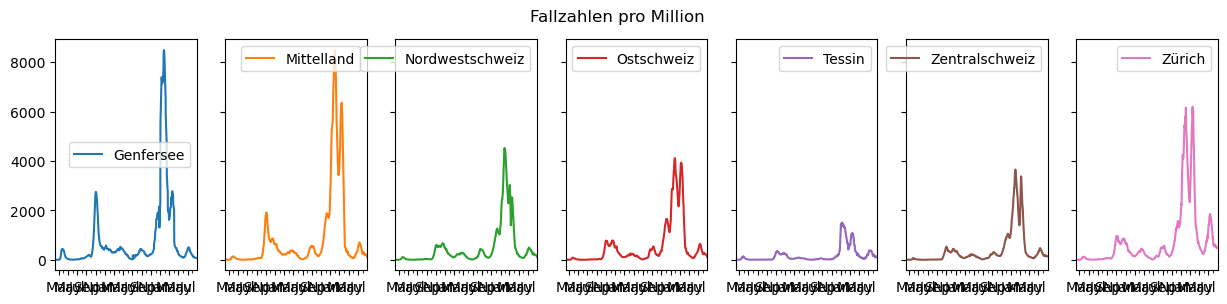

In [33]:
axes = df_inz_reg_pc_7d.plot(subplots=True, layout=(1,7), sharey=True, figsize=(15,3), title="Fallzahlen pro Million")
axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
axes[0][0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

- Fill between: Median der Kantone, höchster und tiefster Kanton

In [34]:
import matplotlib.pyplot as plt

In [35]:
x_values = df_inz_reg_pc_7d.index
y_mins = df_inz_reg_pc_7d.min(axis=1)
y_maxes = df_inz_reg_pc_7d.max(axis=1)
y_median = df_inz_reg_pc_7d.median(axis=1)

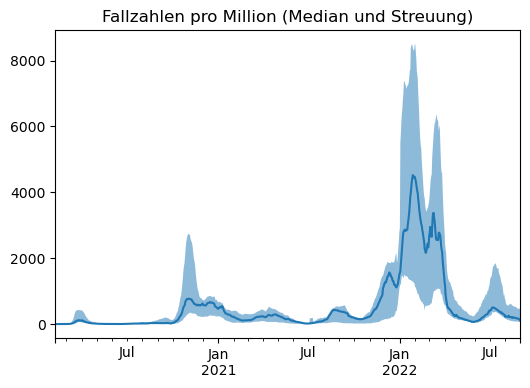

In [36]:
y_median.plot(figsize=(6,4), title='Fallzahlen pro Million (Median und Streuung)')
plt.fill_between(x_values, y_mins, y_maxes, alpha=0.5)